# Geospatial Matcher

In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data


In [7]:
# Input files
# From notebook 2.1 (OpenStreetMaps)
OSM_BUILDINGS_78733 = 'data/all_osm_buildings_78733.geoparquet'
OSM_BUILDINGS_78741 = 'data/all_osm_buildings_78741.geoparquet'
# From notebook 2.2 (TCAD parcels)
TCAD_PARCELS_78733 = 'data/processed/tcad_gis_parcels_78733.parquet'
TCAD_PARCELS_78741 = 'data/processed/tcad_gis_parcels_78741.parquet'
# From notebook 1.2 (TCAD)
TCAD_RECORDS_78733_78741_SINGLE = 'data/processed/tcad_78733_78741_merged_tables.parquet'

# Output files
GEOSPATIAL_MATCH_78733 = 'data/tcad_osm_geomatch_78733_single_fam.geoparquet'
GEOSPATIAL_MATCH_78741 = 'data/tcad_osm_geomatch_78741_single_fam.geoparquet'

In [8]:
# TCAD Single Family Homes Property Records
tcad_single_fam = pd.read_parquet(TCAD_RECORDS_78733_78741_SINGLE)

# TCAD Property Polygons (GIS)
tcad_parcel_78733 = gpd.read_parquet(TCAD_PARCELS_78733)
tcad_parcel_78741 = gpd.read_parquet(TCAD_PARCELS_78741)

# OSM Building Footprints
all_osm_buildings_78733 = gpd.read_parquet(OSM_BUILDINGS_78733)
all_osm_buildings_78741 = gpd.read_parquet(OSM_BUILDINGS_78741)

when using sindex.query. The bboxes for both dataframes are calculated. Then the overlapping ones are identified.
In the return indicies, the indices are [right df, left df]. One mistake to be aware of is not to use the indices of the return.
Order from input to output is crossed.


In [9]:
import pandas as pd
# TODO: drop node
# Input: tcad.query(osm) --> [[osm],[tcad]]
# possible_matches_index =
# This contains a two step operation. First, the sindex.query calculates the bboxes of polygons for both dfs, and then identifies the intersections of these
# boxes to identify "possible matches". By adding a predicate, these actual geometries of these possible matches are then compared using the specified operation
# to get precise matches. Note: the overlap predicate checks for a partial overlap and is useless when a polygon is fully inside another. Use intersects instead.


def geospatial_match(*, tcad_parcels: gpd.GeoDataFrame,
                     osm_bldgs: gpd.GeoDataFrame):
    matches = pd.DataFrame(
        tcad_parcels['geometry'].sindex.query(
            osm_bldgs['geometry'],
            predicate='intersects')).T
    matches = gpd.GeoDataFrame(matches)
    matches['tcad'] = tcad_parcels.iloc[matches[1]]['PROP_ID'].values
    matches['osmid'] = osm_bldgs.iloc[matches[0]
                                      ].index.get_level_values('osmid')

    matches['osm_element_type'] = osm_bldgs.iloc[matches[0]
                                                 ].index.get_level_values('element_type')
    matches['tcad_geometry'] = gpd.GeoSeries(matches['tcad'].map(
        tcad_parcels.set_index('PROP_ID')['geometry'].to_dict()))
    matches['osm_geometry'] = gpd.GeoSeries(matches['osmid'].map(
        osm_bldgs.reset_index().set_index("osmid")['geometry'].to_dict()))

    matches['pct_bldg_in_parcel'] = gpd.GeoSeries(matches['tcad_geometry']).intersection(
        gpd.GeoSeries(matches['osm_geometry'])).area/gpd.GeoSeries(matches['osm_geometry']).area
    matches = matches

    print(f'TCAD records in 78733: {len(tcad_parcels)}')
    print(f'OSM buildings in 78733: {len(osm_bldgs)}')
    print(f'\nNumber of matches: {len(matches)}')
    print(f'OSM buildings with multiple TCAD entries (potential false positives): {
          matches['osmid'].duplicated().sum()}')
    print(f'TCAD parcels with multiple OSM buildings (potential false positives): {
          matches['tcad'].duplicated().sum()}')
    return matches


def dedupe_and_clean(df):
    # 1. Drop where pct_area is null.
    # 2. Drop duplicates by keeping entries with largest percent area. If osm building is 60% in tcad parcel A, and 
    # 40% percent in tcad parcel B, then we say it belongs to parcel A.
    df = (df.dropna(subset='pct_bldg_in_parcel')
          .sort_values(['osmid', 'pct_bldg_in_parcel'], ascending=False)
          .drop_duplicates(subset='osmid')
          .drop(columns=[0, 1]))

    return df


def filter_single_fam(df, filter_df=tcad_single_fam):
    matches_single_fam = df[df['tcad'].isin(filter_df['prop_id'])].copy()

    # TODO: fine tune to only remove osm tag man_made=*not a buildnig*
    # Assumption: ignore detached dwelling units and garage to reduce counts b/c osm labels things like storage tanks as buildings.
    # So if there are multiple buildings in the same tcad parcel, we only keep the largest one.
    matches_single_fam = matches_single_fam.sort_values(
        ['tcad', 'pct_bldg_in_parcel'],
        ascending=False).drop_duplicates('tcad').reset_index(drop=True)

    print("\nAfter cleaning and filtering")
    print(f'\nNumber of matches: {len(matches_single_fam)}')
    print(f'OSM buildings with multiple TCAD entries (potential false positives): {
          matches_single_fam['osmid'].duplicated().sum()}')
    print(f'TCAD parcels with multiple OSM buildings (potential false positives): {
          matches_single_fam['tcad'].duplicated().sum()}')
    return matches_single_fam


result_78733 = (geospatial_match(
    tcad_parcels=tcad_parcel_78733, osm_bldgs=all_osm_buildings_78733)
    .pipe(dedupe_and_clean).pipe(filter_single_fam))
result_78741 = (geospatial_match(
    tcad_parcels=tcad_parcel_78741, osm_bldgs=all_osm_buildings_78741).pipe(
    dedupe_and_clean).pipe(filter_single_fam))

TCAD records in 78733: 3589
OSM buildings in 78733: 4659

Number of matches: 5423
OSM buildings with multiple TCAD entries (potential false positives): 768
TCAD parcels with multiple OSM buildings (potential false positives): 2253

After cleaning and filtering

Number of matches: 2761
OSM buildings with multiple TCAD entries (potential false positives): 0
TCAD parcels with multiple OSM buildings (potential false positives): 0
TCAD records in 78733: 4356
OSM buildings in 78733: 8646

Number of matches: 10555
OSM buildings with multiple TCAD entries (potential false positives): 1913
TCAD parcels with multiple OSM buildings (potential false positives): 6773

After cleaning and filtering

Number of matches: 2331
OSM buildings with multiple TCAD entries (potential false positives): 0
TCAD parcels with multiple OSM buildings (potential false positives): 0


Edge cases:
A storage tank spanning two parcels: https://www.openstreetmap.org/way/912161860 122783 122784


<Axes: >

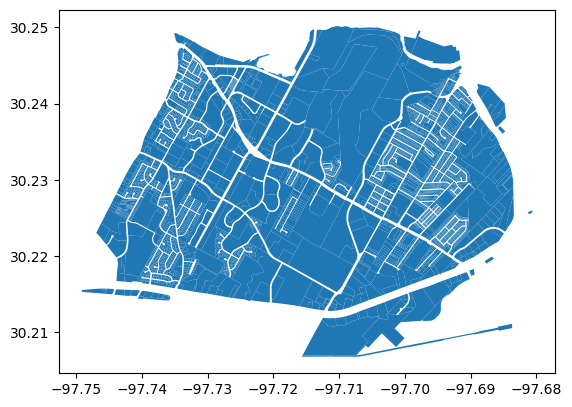

In [9]:
tcad_parcel_78741.plot()

In [13]:
# Here is an example of the results. The important columns are the tcad property id and the osmid since we can use them to lookup more information.
result_78733

,tcad,osmid,osm_element_type,tcad_geometry,osm_geometry,pct_bldg_in_parcel
0,968062,383127380,way,"POLYGON ((-97.86369 30.32500, -97.86395 30.325...","POLYGON ((-97.86386 30.32485, -97.86389 30.324...",1.000000
1,963504,383127065,way,"POLYGON ((-97.87410 30.32867, -97.87408 30.328...","POLYGON ((-97.87407 30.32887, -97.87415 30.328...",1.000000
2,959088,383126607,way,"POLYGON ((-97.85505 30.33077, -97.85619 30.330...","POLYGON ((-97.85563 30.33078, -97.85550 30.330...",1.000000
3,948065,383138654,way,"POLYGON ((-97.87203 30.34547, -97.87230 30.346...","POLYGON ((-97.87215 30.34552, -97.87217 30.345...",1.000000
4,939197,383139808,way,"POLYGON ((-97.86841 30.34501, -97.86843 30.345...","POLYGON ((-97.86885 30.34470, -97.86884 30.344...",1.000000
...,...,...,...,...,...,...
2756,113910,382483067,way,"POLYGON ((-97.88277 30.28991, -97.88276 30.290...","POLYGON ((-97.88277 30.29002, -97.88287 30.290...",1.000000
2757,113909,382482497,way,"POLYGON ((-97.88276 30.29014, -97.88276 30.290...","POLYGON ((-97.88287 30.29010, -97.88298 30.290...",0.926198
2758,113908,382482491,way,"POLYGON ((-97.88279 30.29035, -97.88284 30.290...","POLYGON ((-97.88300 30.29037, -97.88300 30.290...",0.991435
2759,113907,382482485,way,"POLYGON ((-97.88284 30.29057, -97.88289 30.290...","POLYGON ((-97.88314 30.29069, -97.88313 30.290...",1.000000


In [10]:
result_78733.to_parquet(GEOSPATIAL_MATCH_78733)
result_78741.to_parquet(GEOSPATIAL_MATCH_78741)